In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score

from ymaeda_tools.read_dGM import read_Mseq1
from ymaeda_tools.inversion import winv_lstsq
from ymaeda_tools.dft import exifft_timeshift

# This script verifies that the python functions performing the linear inversion return
# the same results as the original YMAEDA_TOOLS functions

STARTTIME = time.time()

base = "/Volumes/MAC Backup/Final Year Projects/Shinmoedake Data/kirishima_invert/inversion_results_dump_new/"
main_dir = base + "inversion_result_residuals117/t60_p100/x-10900y-121100z1000/"

dt = 0.1 # time step size

# read the original M.seq1 output from YMAEDA_TOOLS
mt = read_Mseq1(main_dir)

t = np.arange(0, dt * len(mt), dt)

# load the G and d data and performs inversion using least squares method using the python codes
mest = winv_lstsq(main_dir, w = 0)
m = exifft_timeshift(mest, 1000) / dt # remember the 1/dt factor
mr = np.real(m)

print("Time elapsed: {:.3f}s".format(time.time() - STARTTIME))

Time elapsed: 27.275s


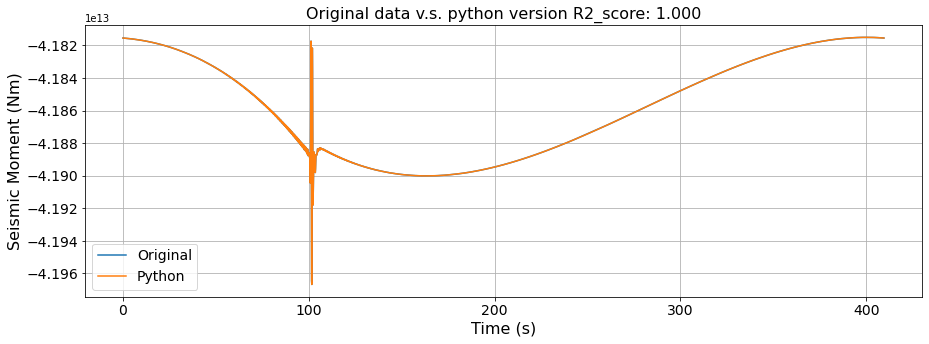

In [3]:
plt.figure(figsize = (15, 5))
plt.title("Original data v.s. python version R2_score: {:.3f}".format(r2_score(mt, mr)), fontsize = 16)
plt.plot(t, mt)
plt.plot(t, mr)
plt.xlabel('Time (s)', fontsize = 16)
plt.ylabel('Seismic Moment (Nm)', fontsize = 16)
plt.legend(["Original", "Python"], fontsize = 14)
plt.grid(True)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()